# Demo 2: AutoRegressive Integrated Moving Average (ARIMA) model
This demo we will demo code for using AutoRegressive Integrated Moving Average (ARIMA) model to solve the regression problem:
-   Problem: Predict stock close price of Taiwan Semiconductor Manufacturing Company (TSMC). It means that we consider the stock close price as a time series dataset (y = f(t)),
    -   y: stock close price
    -   t: time
    -   We have to find the function f (regression problem)
-   Dataset: Stock dataset which is getting from yahoo finance database by using the yfinance package.
-   Library packages:
    -   Statsmodels (is a Python module that provides classed and functions for the estimation of many different statistical models,...)
    -   yfinance (offers a threaded and Pythonic way to download market data from Yahoo finance.)
    -   pandas (A fast and efficient dataframe object for data manipulation with integrated indexing, reading and writing data between in-memory data structures and different formats: CSV, Microsoft Excel, SQL databases)
    -   ...

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Getting the stock dataset of TSMC
-   Exploring about the dataset
-   Normalize or standardlize dataset (if needed)
-   Devide dataset to trainset and testset
## 1. Task 1: Getting model from statsmodels:
*   ARIMA model

Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components. The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows all specialized cases, including

-   autoregressive models: AR(p)

-   moving average models: MA(q)

-   mixed autoregressive moving average models: ARMA(p, q)

-   integration models: ARIMA(p, d, q)

-   seasonal models: SARIMA(P, D, Q, s)

-   regression with errors that follow one of the above ARIMA-type models

[https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html](Documents of statsmodels.tsa.arima.model.ARIMA)

*   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Compute the metrics (quantitative measurements)
    -   Regression task: R2_score, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), ...
## 3. Task 3: Performing a rolling regression
-   A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of full sample.
*********************************************************


# Import all packages

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import numpy as np

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_data_stock_yfinance.ipynb to get detail of demo code for this step

### 0.1. Getting stock data of TSMC with company Code: TSM from 2 years ago.

In [2]:
# Getting stock data of Company Name: TSMC with Company Code: TSM
"""
-   start_date: start time to getting data stock
-   end_data: end time to getting data stock
-   data_source: where to getting data
"""
now = datetime.now()
data_source = 'yahoo'
start_date = now.today() - relativedelta(years  = 2)
end_date = now.today()
print(start_date)
print(end_date)
df_TSM = yfinance.download("TSM",start=start_date,end=end_date)

2021-11-14 15:33:46.340457
2023-11-14 15:33:46.340546
[*********************100%%**********************]  1 of 1 completed


### 0.2. Exploring the data:
See the file Demo_data_stock_yfinance.ipynb for more detail.

In [3]:
# Type of data after getting from yfinance:
print(type(df_TSM))

<class 'pandas.core.frame.DataFrame'>


In [4]:
# Data info:
df_TSM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2021-11-15 to 2023-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [5]:
# Showing most recently five days in our dataframe
df_TSM.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-07,92.250000,93.050003,91.750000,92.410004,92.410004,6241300
2023-11-08,93.330002,93.440002,91.930000,92.000000,92.000000,6537700
2023-11-09,92.629997,93.370003,91.599998,91.620003,91.620003,8166000
2023-11-10,94.040001,97.750000,93.610001,97.440002,97.440002,19281700
2023-11-13,97.010002,97.180000,95.720001,96.419998,96.419998,9522100


### 0.3. Visualize data in stock form.

In [6]:
# Preparing data to plot: range of close open, range of low high, check close >= open for each day
df_TSM["Y_price"] = (df_TSM["Open"] + df_TSM["Close"])/2
df_TSM["Y_error"] = (df_TSM["Open"] - df_TSM["Close"]).abs()/2
df_TSM["HL"] = (df_TSM["High"] + df_TSM["Low"])/2
df_TSM["HL_error"] = (df_TSM["High"] - df_TSM["Low"]).abs()/2
df_TSM["IsPositive"] = df_TSM["Close"] >= df_TSM["Open"]

In [7]:
# We only plot most recently 100 days stock data of TSMC:
data_to_plot = df_TSM.tail(100)

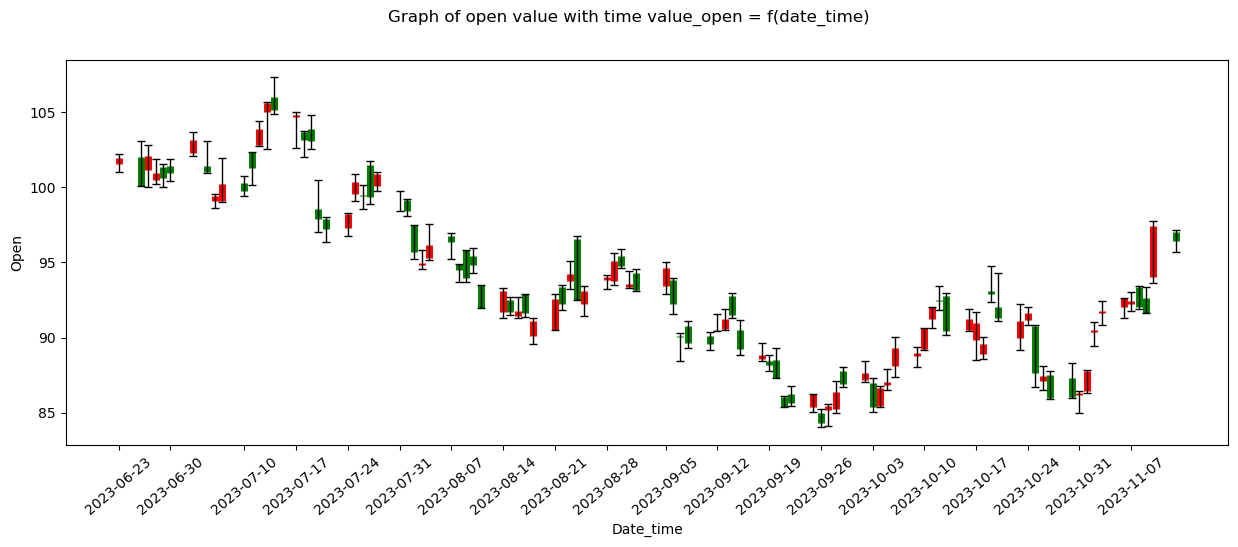

In [8]:
# Visualize data
colors = {True:'red',False:'green'}

fig, ax = plt.subplots(1,1,figsize = (15,5))
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Open"],color='g')
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Close"],color='red')
""" 
The following line of code plot bar range open close, color base on
the comparision of open price and close price
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["Y_price"],
            data_to_plot["Y_error"],
            linewidth = 5, 
            capsize=0,
            ls='none',
            ecolor = data_to_plot['IsPositive'].map(colors))
"""
The following line of code plot black interval with the width = high - low
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["HL"],
            data_to_plot["HL_error"],
            linewidth = 1,
            capsize=3,
            color='k',
            ls='none')

fig.suptitle("Graph of open value with time value_open = f(date_time)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Open")
ax.set_xticks(data_to_plot.index.tolist()[::5]) #Without this it is too dense, with this we only display every after 5 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center
plt.show()

### 0.4. Prepare data for training model:
-   We consider the Close column in our data set as timeseries data
-   Divide data into two parts:
    -   For training: first 400 rows
    -   For testing: start from row 400th

In [9]:
y_train = df_TSM["Close"][:400]
y_test = df_TSM["Close"][400:]

## 1. Task 1: Getting model from statsmodels package
### 1.1. Getting model from statsmodels:
AutoRegressive Integrated Moving Average Model is a class of statistical models for analyzing and forecasting time series data. 
The key aspects of the model are:
-   AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
-   I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
-   MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
-   p: The number of laf observations included in the model, also called the laf order.
-   d: The number of times that the raw observations are differenced, also called the degree of differencing.
-   q: The size of the moving average window, also called the order of moving average.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

In [10]:
# Create a ARIMA model with p = 4,d = 0, q = 2 
p,d,q = (4,0,2)
arima_temp = ARIMA(y_train,order=(p,d,q))


/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 1.2. Training for our model

In [11]:
arima_trained = arima_temp.fit()

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Obtain value of parameters after training/fitting
print("Coefficients:", arima_trained.params)

Coefficients: const     93.547341
ar.L1     -0.506662
ar.L2      0.579099
ar.L3      0.927513
ar.L4     -0.029996
ma.L1      1.538592
ma.L2      0.942516
sigma2     5.063969
dtype: float64


## 2. Task 2: Evaluating the performance of trained model on the testset
### 2.1. Predict the close price for time series on the test part

In [13]:
pred_test = arima_trained.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
date_index = df_TSM.index.to_list()[400]

In [15]:
print(f"Predict Close value at time = {date_index} is:{pred_test.iloc[0]},\n true Close value is: {y_test.iloc[0]}")

Predict Close value at time = 2023-06-21 00:00:00 is:103.6170797381067,
 true Close value is: 101.63999938964844


### 2.2. Compute the metrics (quantitative measurements)

In [16]:
# R2-score:
score = r2_score(y_pred=pred_test,y_true=y_test)
print("The R2 score of our model is: ",score)

The R2 score of our model is:  -0.9871781137263969


In [17]:
# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_test,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

The mean absolute error of our model is:  6.7315666607042965


In [18]:
#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_test,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The root mean squared error of our model is: 7.718169308246719


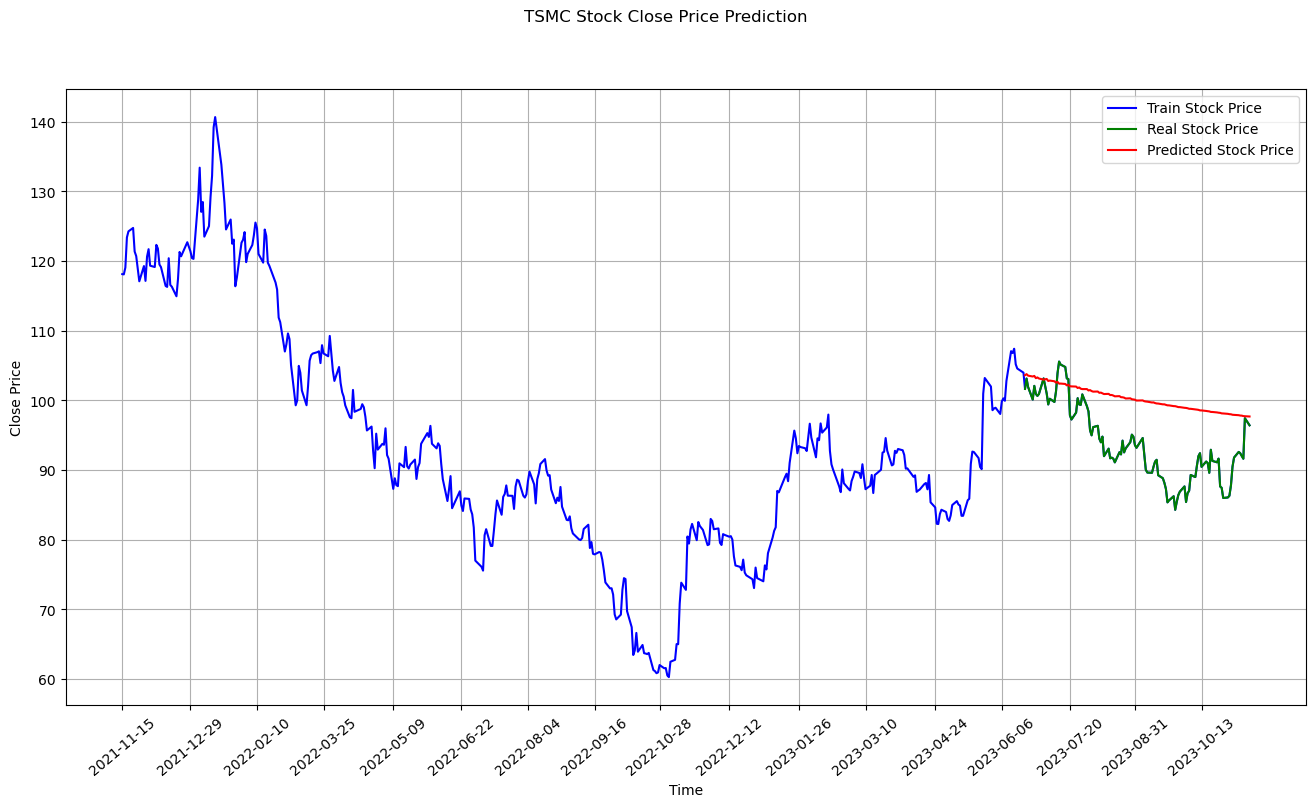

In [19]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

## 3. Task 3: Performing a rolling regression
A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of test dataset.

In [20]:
print(y_test.iloc[0])

101.63999938964844


In [21]:
# Performing a rolling forecasts
history = [y for y in y_train]
pred_roll = []
for i in range(len(y_test)):
    # Create AR model and fit the history data to this model:
    arima_model_temp = ARIMA(history,order=(p,d,q))
    arima_trained = arima_model_temp.fit()
    # forecasts and get first forecasts (the timeseries right after history)
    y_pred = arima_trained.forecast()[0]
    # add the pred value to the list pred_roll
    pred_roll.append(y_pred)
    # update for history by appending one observation
    obs = y_test.iloc[i] # update the true close value
    history.append(obs)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

In [22]:
# report performance
# R2-score:
score = r2_score(y_pred=np.array(pred_roll),y_true=np.array(y_test))
print("The R2 score of our model is: ",score)

# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_roll,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_roll,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The R2 score of our model is:  0.9164764725991907
The mean absolute error of our model is:  1.2080407713722043
The root mean squared error of our model is: 1.5823418597174324


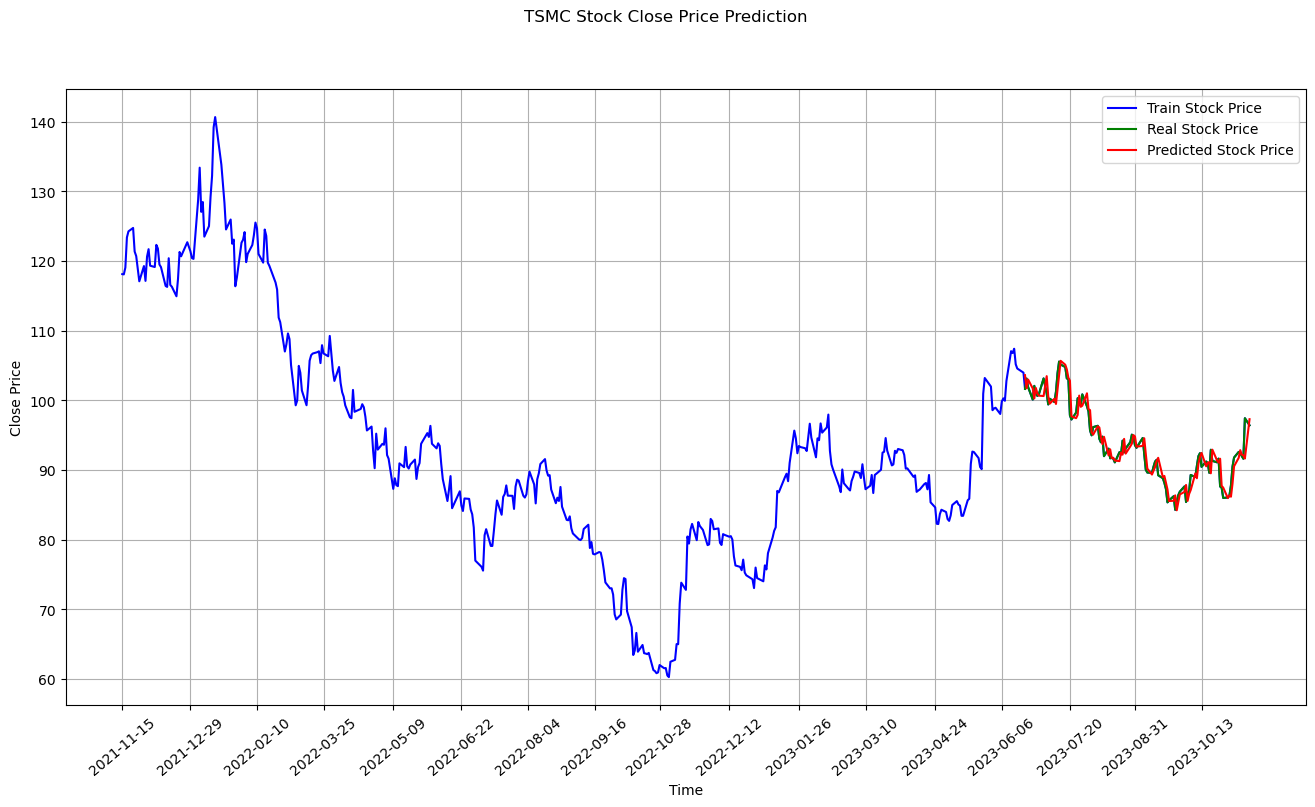

In [23]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_roll, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

## 4. Task 4: Considering the Autocorrelation and the Partial Autocorrelation functions:
How to choose values of p,d and q?
-   Test for stationarity using the augmented dickey fuller test.
-   If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the value of d.
-   If the data is getting stationary then draw the autocorrelation and parital autocorrelation graph of the data.
-   Draw a partial autocorrelation graph (ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p.
-   Draw an autocorrelation graph (ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.

### 4.1. Augmented Dickey-Fuller Test

In [24]:
result = adfuller(df_TSM['Close'])
print(f"ADF Statistic:{result[0]}")
print(f'p-value: {result[1]}')
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic:-2.1975462515064548
p-value: 0.20713723111729426
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


-   Start with ADF test:

    -   p-value = 0.207 > 0.05, then the time series if non-stationary
    -   have to differentiate data and check the ADF test again

In [37]:
# differentiate data and check ADF test
result = adfuller(df_TSM['Close'].diff().dropna())
print(f"ADF Statistic:{result[0]}")
print(f'p-value: {result[1]}')
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic:-10.175911167556858
p-value: 6.893535176415615e-18
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


This time p-value is less than 0.05, the 1-diff data is stationary. d = 1

#### 4.1.a. Finding the value of the d parameter


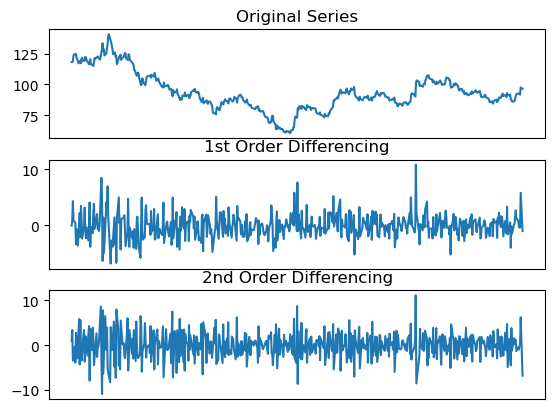

In [25]:
fig,ax = plt.subplots(3)
ax[0].plot(df_TSM['Close'])
ax[0].set_title("Original Series")
ax[0].axes.xaxis.set_visible(False)
# 1st Differencing
ax[1].plot(df_TSM["Close"].diff())
ax[1].set_title("1st Order Differencing")
ax[1].axes.xaxis.set_visible(False)
# 2nd Differencing
ax[2].plot(df_TSM["Close"].diff().diff())
ax[2].set_title("2nd Order Differencing")
ax[2].axes.xaxis.set_visible(False)

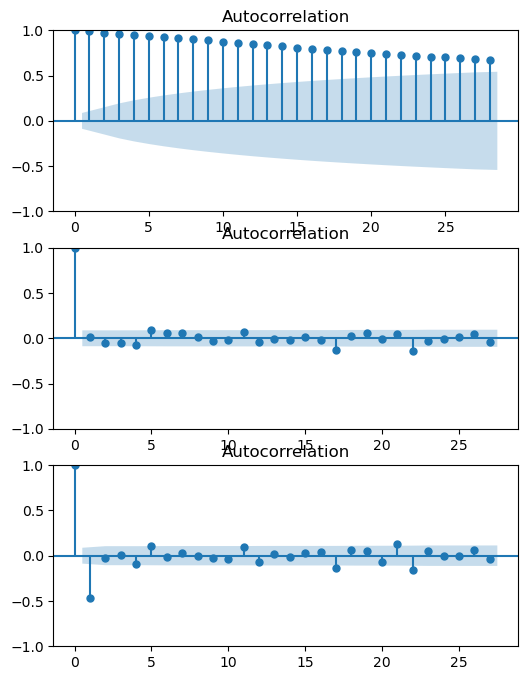

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize = (6,8))
fig = plot_acf(df_TSM['Close'], ax=ax1)
fig = plot_acf(df_TSM['Close'].diff().dropna(), ax=ax2)
fig = plot_acf(df_TSM['Close'].diff().diff().dropna(), ax=ax3)


#### 4.1.b. Finding the value of the p parameter

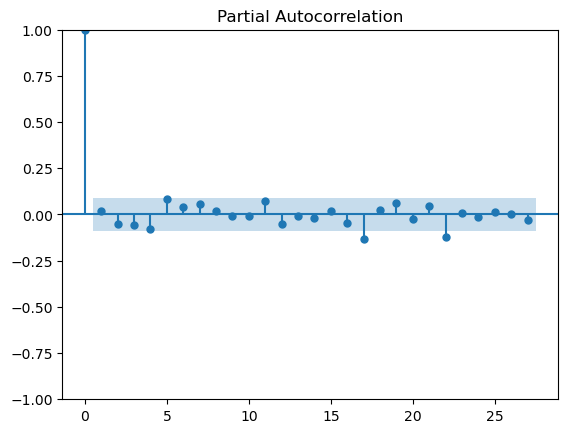

In [41]:
fig = plot_pacf(df_TSM['Close'].diff().dropna())

-   Ignore the 0th one
-   Check the lag which is very close/inside to the dense part

Here, lags 1,2,3,4 is inside the dense part
 p optimal value using the plot is 1

#### 4.1.c. Finding the value of the q parameter

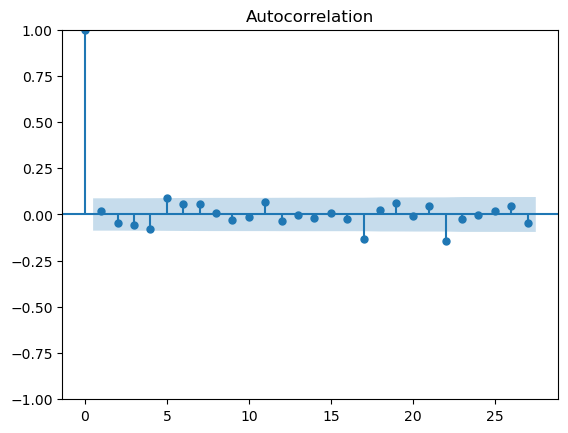

In [42]:
fig = plot_acf(df_TSM['Close'].diff().dropna())

q optimal value is 1

### 4.2. Create model with optimal p, d, q

In [43]:
# Create a ARIMA model with optimal p = 1,d = 1, q = 1 
p,d,q = (1,1,1)
arima_temp_op = ARIMA(y_train,order=(p,d,q))

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
# Training for our model
arima_trained_op = arima_temp_op.fit()

In [45]:
# Obtain value of parameters after training/fitting
print("Coefficients:", arima_trained.params)

Coefficients: [ 9.37091778e+01 -3.38301046e-01  4.33929959e-01  9.40427737e-01
 -7.03970637e-02  1.37258607e+00  9.66984020e-01  4.56868183e+00]


In [46]:
print(arima_trained_op.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  400
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -892.735
Date:                Tue, 14 Nov 2023   AIC                           1791.470
Time:                        16:09:34   BIC                           1803.437
Sample:                             0   HQIC                          1796.209
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6285      1.243      0.506      0.613      -1.807       3.064
ma.L1         -0.6460      1.214     -0.532      0.595      -3.026       1.734
sigma2         5.1396      0.268     19.177      0.0

In [47]:
# predict
pred_test_op = arima_trained_op.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [48]:
date_index = df_TSM.index.to_list()[400]

In [49]:
print(f"Predict Close value at time = {date_index} is:{pred_test_op.iloc[0]},\n true Close value is: {y_test.iloc[0]}")

Predict Close value at time = 2023-06-21 00:00:00 is:103.999035828296,
 true Close value is: 101.63999938964844


In [50]:
# R2-score:
score = r2_score(y_pred=pred_test_op,y_true=y_test)
print("The R2 score of our model is: ",score)
# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_test_op,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)
#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_test_op,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The R2 score of our model is:  -3.5153889210885225
The mean absolute error of our model is:  10.33168046856363
The root mean squared error of our model is: 11.634386442767


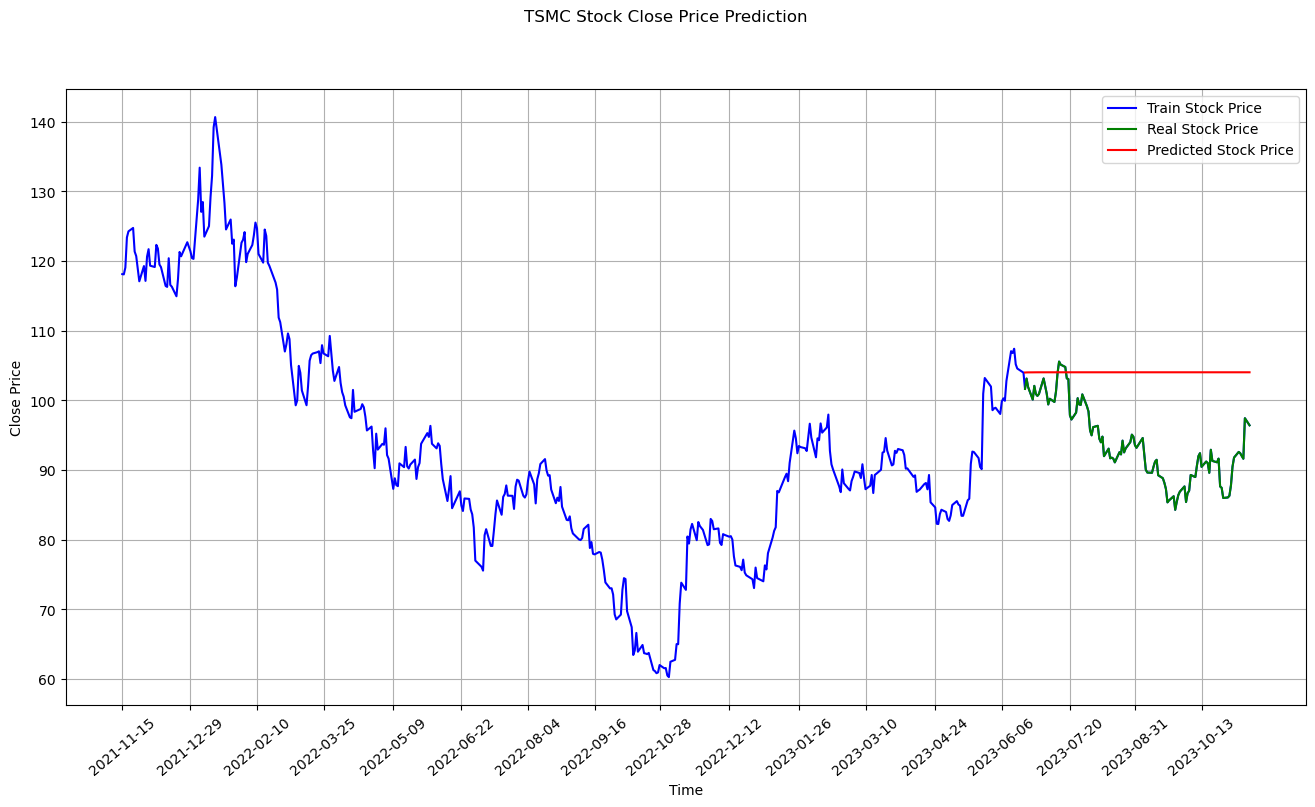

In [51]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test_op, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

In [52]:
# Performing a rolling forecasts with optimal p,d,q
p,d,q = (1,1,1)
history = [y for y in y_train]
pred_roll_op = []
for i in range(len(y_test)):
    # Create AR model and fit the history data to this model:
    arima_model_temp = ARIMA(history,order=(p,d,q))
    arima_trained = arima_model_temp.fit()
    # forecasts and get first forecasts (the timeseries right after history)
    y_pred = arima_trained.forecast()[0]
    # add the pred value to the list pred_roll
    pred_roll_op.append(y_pred)
    # update for history by appending one observation
    obs = y_test.iloc[i] # update the true close value
    history.append(obs)

In [53]:
# report performance
# R2-score:
score = r2_score(y_pred=np.array(pred_roll_op),y_true=np.array(y_test))
print("The R2 score of our model is: ",score)

# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_roll_op,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_roll_op,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The R2 score of our model is:  0.916226205379092
The mean absolute error of our model is:  1.2163147672362102
The root mean squared error of our model is: 1.5847107257588313


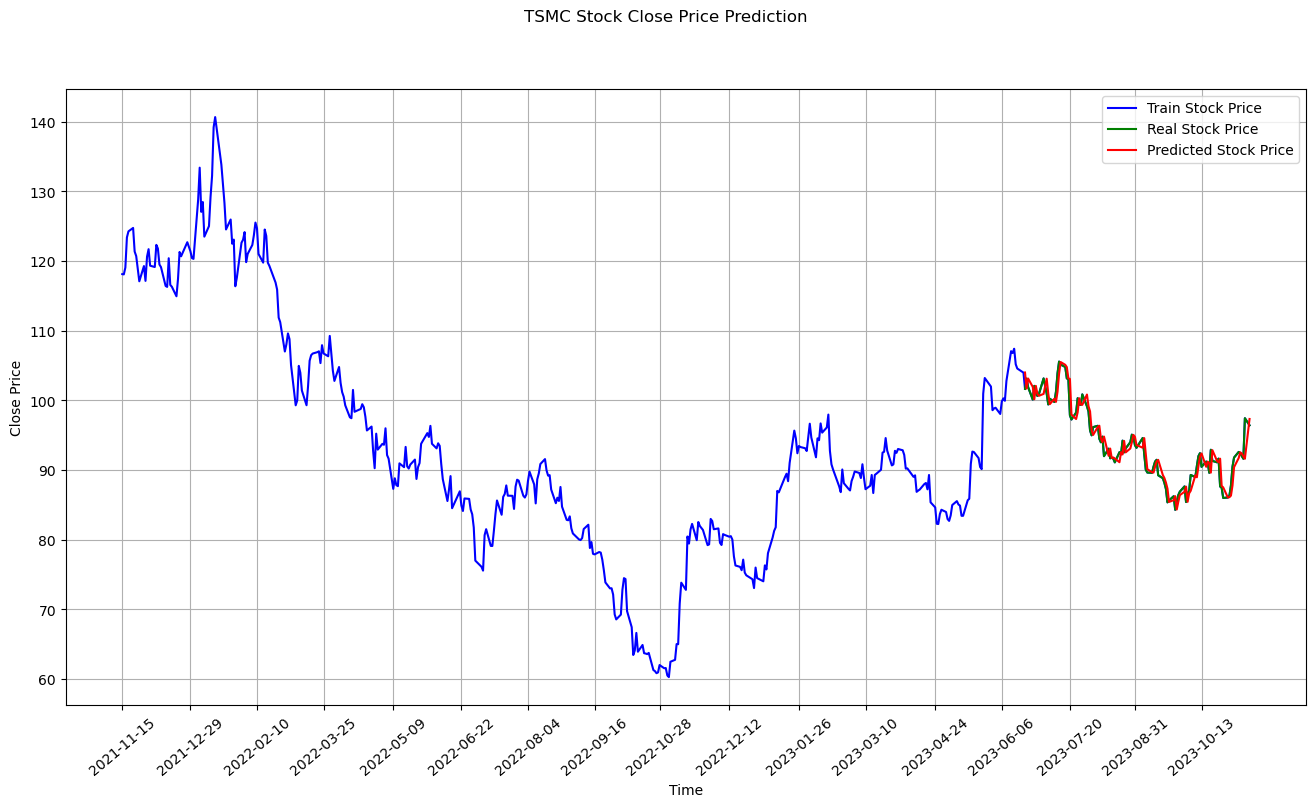

In [54]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_roll_op, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()